### Import libraries

In [1]:
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [2]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

### Data Exploration and Visualization

Data Exploration and Visualization helps us to understand the data as well as preprocessing steps in a better way.

### Visualization of Audio signal in time serise domain

Now, we'll visualize the audio in the time series domain:

In [3]:
train_audio_path = 'C:/Users/JongminKim/tensorflow-speech-recognition-challenge/train/audio/'

16000
16000


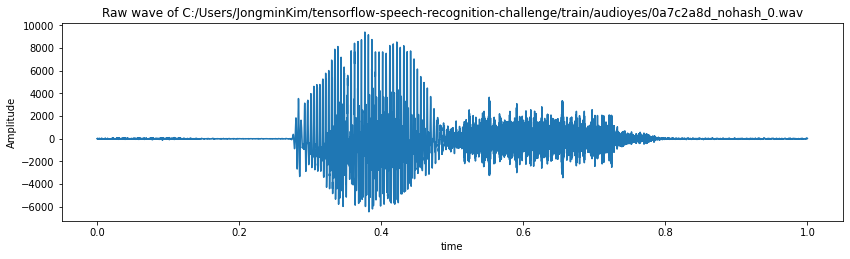

In [4]:
train_audio_path = 'C:/Users/JongminKim/tensorflow-speech-recognition-challenge/train/audio/'
filename = 'yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'C:/Users/JongminKim/tensorflow-speech-recognition-challenge/train/audioyes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
print(sample_rate)
print(len(samples))

#sample_rate: 음성 파일의 주파수(초당 샘플 수, 스칼라)
#sample: 그 수치(위상, 벡터)

### Sample rate

Let us now look ata the sampling rate of the audio signals

In [5]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)
np.array(samples, dtype='float64')

16000


array([ 14.,  -7., -14., ...,  19.,  20.,  27.])

### Resampling

From the above, we can understand that the sampling rate of the signal is 16000hz. Let us resample it to 8000hz since most of the speech related frequencies are present in 8000hz

In [6]:
samples=np.array(samples, dtype='float64')

samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

# librosa 라이브러리를 통해 resample. 이 경우 기존의 16000Hz를 8000Hz로 downsampling한 것이다.

Now, let's understand the number of recordings for each voice command:

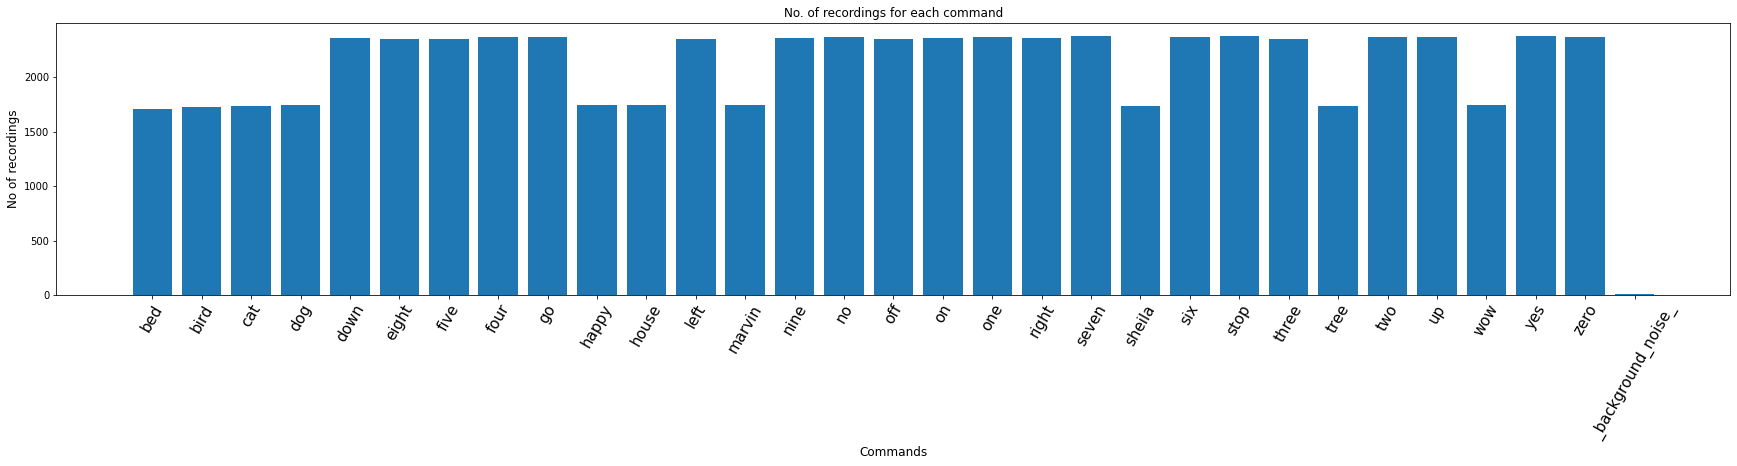

In [7]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

### Duration of recordings

What's next? A look at the distribution of the durarion of rcordings:

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

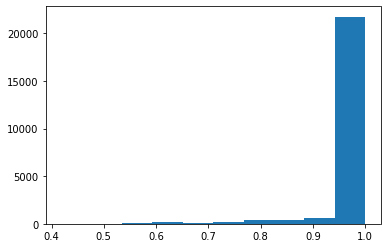

In [8]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

음성파일의 길이를 파악해보았을 때 거의 대부분의 파일이 1초 정도의 길이인 것을 알 수 있다. 1초보다 짧은 길이의 음성파일도 일부 존재한다.

### Preprocessing

In the data exploration part earlier, we have seen that the duration of a few recordings is less than 1 second and the sampleing rate is too high. So, let us read the audio waves and udds the below-preprocessing steps to deal with this.

Here are the two steps we'll follow:

* Resampling
* Removing shorrter commands of less than 1 second

Let us define these preprocessing steps in the below code snippet:

In [9]:
train_audio_path = 'C:/Users/JongminKim/tensorflow-speech-recognition-challenge/train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)
            
#전체 train data를 16000Hz에서 8000Hz로 resampling을 진행한다.
#resampling한 것들 중에서 길이가 1초가 되지 않는 데이터를 제거한다.(samples의 길이가 8000이 아닌 데이터를 제외시킨다.)

yes
no
up
down
left
right
on
off
stop
go


Convert the output labels tp integer encoded:

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

#10개의 label에 대해 정수로 encoding해준다.

Now, convert the integer encoded labels to a one-hot vector since it is a multi-classifiaction problem:

In [11]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

#keras.utils패키지의 to_categorical함수를 통해 labels를 one-hot-encoding시켜준다.

Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:

In [12]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

#Conv1D의 input이 3D가 되어야하기 때문에 기존의 2Darray를 3D로 reshape시켜준다.

In [13]:
all_wave.shape

(21312, 8000, 1)

### Split into train and validation set
Next, we will train the model on 80% of the data and valdiate on the remaining 20%:

In [14]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

### Model Architercture for this problem
We will build the speech-to-text model using conv1d. Conv1d is a convoutional neural network which performs the convolution along only one dimension.

### Model building
Let us implement the model using Keras functional API.

In [15]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.2)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.2)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()


#Conv1D와 Conv2D, Conv3D의 차이
#합성곱의 방향: 한 방향(가로)vs두 방향(가로,세로)vs세 방향(가로,세로,높이)
#출력값:1-D Array(vector)vs2-D Array(matrix)vs3-D Array(tensor)


#Conv1D(filters,kernel_size,strides=1,padding='valid',activation=None, strides=1)
#이미지 데이터 때 쓰는 Conv2D와 같아보이지만 필터의 형태가 다르다.
#Conv1D는 kernel_size를 1개의 정수로 표현, Conv2D는 (int,int)로 표현된다.
#Conv1D는 필터의 입력값의 차원 수와 높이가 동일하게 연산되기 때문에 가로 길이만 설정해주면 된다
#padding='valid'==no padding->size가 줄어든다.

#Pooling: feature map의 크기를 줄이거나 주요한 특징을 뽑아내기 위해서 합성곱 신경망 이후에 적용되는 기법
#MaxPooling1D(pool_size=2,strides=None,padding='valid',data_format=None)이 기본
#pool_size : 풀링을 적용할 필터의 크기(pool_size클수록 output크기 작아짐)

#Dropout
#신경망 모델의 overfitting 문제를 해결해주는 방법. 전체 입력값 중 rate의 크기만큼을 0으로 만든다.
#Dropout(rate)

#Dense
#Dense(unit,activation=None)
#unit:output의 크가

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

Define the  loss function to be categorical cross-entropy since it is a multi-classifiaction problem:

In [16]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.00001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Let us rain the model on a bathc size of 32 and the evaluate the performance on the holdout set:

In [18]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=8, validation_data=(x_val,y_val))
#원래 kernal에서의 batch_size는 32였지만 GPU용량 부족으로 batch_size를 8까지 줄여서 진행했습니다.

Epoch 1/100
2132/2132 [==============================] - 27s 10ms/step - loss: 2.2856 - accuracy: 0.1239 - val_loss: 2.2628 - val_accuracy: 0.1536
Epoch 2/100
2132/2132 [==============================] - 19s 9ms/step - loss: 2.2122 - accuracy: 0.1652 - val_loss: 2.1631 - val_accuracy: 0.1696
Epoch 3/100
2132/2132 [==============================] - 19s 9ms/step - loss: 2.0900 - accuracy: 0.2064 - val_loss: 1.9819 - val_accuracy: 0.2454
Epoch 4/100
2132/2132 [==============================] - 19s 9ms/step - loss: 1.9357 - accuracy: 0.2665 - val_loss: 1.8310 - val_accuracy: 0.3059
Epoch 5/100
2132/2132 [==============================] - 19s 9ms/step - loss: 1.6872 - accuracy: 0.3618 - val_loss: 1.4618 - val_accuracy: 0.4830
Epoch 6/100
2132/2132 [==============================] - 19s 9ms/step - loss: 1.4967 - accuracy: 0.4383 - val_loss: 1.3098 - val_accuracy: 0.5238
Epoch 7/100
2132/2132 [==============================] - 19s 9ms/step - loss: 1.3585 - accuracy: 0.5070 - val_loss: 1.2723 

Epoch 38/100
2132/2132 [==============================] - 19s 9ms/step - loss: 0.3840 - accuracy: 0.8656 - val_loss: 0.6303 - val_accuracy: 0.7938
Epoch 39/100
2132/2132 [==============================] - 19s 9ms/step - loss: 0.3844 - accuracy: 0.8674 - val_loss: 0.6476 - val_accuracy: 0.7898
Epoch 40/100
2132/2132 [==============================] - 19s 9ms/step - loss: 0.3704 - accuracy: 0.8682 - val_loss: 0.8218 - val_accuracy: 0.7319
Epoch 41/100
2132/2132 [==============================] - 19s 9ms/step - loss: 0.3759 - accuracy: 0.8691 - val_loss: 0.6074 - val_accuracy: 0.8095
Epoch 42/100
2132/2132 [==============================] - 19s 9ms/step - loss: 0.3635 - accuracy: 0.8718 - val_loss: 0.5874 - val_accuracy: 0.8109
Epoch 00042: early stopping


### Diagnostic plot
I'm going to lean on visualization again to understand the performance of the model over a period of time:

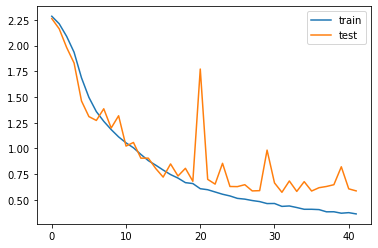

In [19]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()